In [1]:

"""機械学習による異音検知スクリプト プロトタイプ2020年型 Ver:α0.93"""

#%%
# cording = UTF-8

"""標準ライブラリ"""
import sys
import os
import wave
import re
import random
import copy
import time
import datetime
import configparser
import json

"""サードパーティライブラリ"""
import numpy as np
import scipy
import pyaudio
import sklearn
import matplotlib.pyplot as plt
import joblib
import numba

"""個別の関数・クラスのインポート"""
from scipy.signal import spectrogram
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

print ("Numpy version:{0}".format(np.__version__))
print ("Scipy version:{0}".format(scipy.__version__))
print ("Pyaudio version:{0}".format(pyaudio.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("joblib version:{0}".format(joblib.__version__))
print ("numba version:{0}".format(numba.__version__))

#バージョン判定 python実行環境が3.8以前であればtensorflowをインポート
if float(str(sys.version_info[0])+"."+str(sys.version_info[1])) >= 3.8:
    print("cannot use tensorflow!")
else:
    import tensorflow as tf
    #from tensorflow import keras
    print ("Tensorflow version:{0}".format(tf.__version__))
    print ("tf.keras version:{0}".format(tf.keras.__version__))

base_dir = os.path.dirname(__file__)    #カレントフォルダを強制指定

###########################グローバル変数の初期値###########################
"""収音関連のパラメタ"""
br = 8              #ビットレート 8推奨
sr = 22050          #サンプリングレート(Hz) 20050推奨
r_wait = 5          #トリガから収音開始までのウェイト(秒)
r_len = 3           #収音時間(秒)
a_idx = None        #オーディオインデックス番号
disp_spg = True     #収音後、スペクトログラムの表示を行うかどうか Falseは波形表示

"""データセット関連のパラメタ"""
axis_freq = None        #スペクトログラムの周波数軸(リスト)
axis_tme = None         #スペクトログラムの時間軸(リスト)
aug_amt = 512           #水増し回数
file_train = "train_ds" #トレーニングデータセットのファイル名
file_test = "test_ds"   #テストデータセットのファイル名

"""モデル関連のパラメタ"""
exp_ver = 0.999                 #PCAの残存分散率
file_model_pca = "PCAmodel"     #PCAモデルのファイル名
file_model_skAE = "skAEmodel"   #scikit-learn AEモデルのファイル名

"""パス関連"""
data_dir = "data"       #データセットの保管フォルダ名 カレントの直下
save_dir = "waves"      #収音データの保管フォルダ名 dataの下
model_dir = "models"    #モデルファイルの保管フォルダ名 カレントの直下
log_dir = "logs"        #ログファイルの保管フォルダ名 カレントの直下

#############################処理系オブジェクト#############################
"""起動と初期化"""
class Init_Boot:

    def __init__(self):
        #パス関連変数の生成
        self.base_dir = base_dir
        self.data_dir = os.path.join(self.base_dir,data_dir)
        self.save_dir = os.path.join(self.data_dir,save_dir)
        self.model_dir = os.path.join(self.base_dir,model_dir)
        self.log_dir = os.path.join(self.base_dir,log_dir)

        #生成するファイル名変数の生成
        self.file_train = os.path.join(
            self.data_dir,
            str(os.path.splitext(os.path.basename(__file__))[0]
            + "_" + file_train + ".npz")
        )
        self.file_test = os.path.join(
            self.data_dir,
            str(os.path.splitext(os.path.basename(__file__))[0]
            + "_" + file_test + ".npz")
        )
        self.file_model_pca = os.path.join(
            self.model_dir,
            str(os.path.splitext(os.path.basename(__file__))[0]
            + "_" + file_model_pca + ".dat")
        )

        self.file_model_skAE = os.path.join(
            self.model_dir,
            str(os.path.splitext(os.path.basename(__file__))[0]
            + "_" + file_model_skAE + ".dat")
        )

        #他の変数の初期化
        self.br = br
        self.sr = sr
        self.r_wait = r_wait
        self.r_len = r_len
        self.a_idx = a_idx
        self.disp_spg = disp_spg
        self.axis_freq = axis_freq
        self.axis_tme = axis_tme
        self.aug_amt = aug_amt
        self.exp_ver = exp_ver

        #必要なインスタンスの生成
        self.pa = pyaudio.PyAudio()
        self.cfg = configparser.ConfigParser()

    """フォルダの生成"""
    def  elem_gen_folder(self,target_dir):
        if os.path.exists(target_dir):
            pass
        else:
            os.mkdir(target_dir)
            print("Created a directory:{0}".format(target_dir))

    """設定値のセット"""
    def elem_set_ini(self):
        x = self.cfg
        x["General"] = {
            "base_dir" : self.base_dir,
            "data_dir" : self.data_dir,
            "save_dir" : self.save_dir,
            "model_dir" : self.model_dir,
            "log_dir" : self.log_dir,
            "file_train" : self.file_train,
            "file_test" : self.file_test,
            "file_model_pca" : self.file_model_pca,
            "file_model_skAE" : self.file_model_skAE
        }

        x["Rec_param"] = {
            "br" : self.br,
            "sr" : self.sr,
            "r_wait" : self.r_wait,
            "r_len" : self.r_len,
            "disp_spg" : self.disp_spg
        }

        if self.a_idx == None:
            x["Rec_param"]["a_idx"] = ""
        else:
            x["Rec_param"]["a_idx"] = str(self.a_idx)

        x["DS_param"] = {
            "aug_amt" : self.aug_amt
        }

        if self.axis_freq == None:
            x["DS_param"]["axis_freq"] = ""
        else:
            x["DS_param"]["axis_freq"] = self.axis_freq.tolist()

        if self.axis_tme == None:
            x["DS_param"]["axis_tme"] = ""
        else:
            x["DS_param"]["axis_tme"] = self.axis_tme.tolist()

        x["PCA_param"] = {
            "exp_ver" : self.exp_ver
        }

        return x

    """iniファイルへの保存"""
    def elem_save_ini(self,cfg):
        with open(
            os.path.splitext(
                os.path.basename(__file__)
            )[0] + ".ini","w") as cfgfile:
            cfg.write(cfgfile)
        print ("Saved setting parameters.")

    """iniファイルのロード"""
    def elem_load_ini(self):
        x = self.cfg
        x.read(
            os.path.join(
                "./",str(
                    os.path.splitext(
                        os.path.basename(__file__)
                    )[0] + ".ini"
                )
            )
        )
        return x

    """設定値の読み出し"""
    def elem_get_ini(self,cfg):
        x = cfg

        #読み出し
        self.base_dir = x.get("General","base_dir")
        self.data_dir = x.get("General","data_dir")
        self.save_dir = x.get("General","save_dir")
        self.model_dir = x.get("General","model_dir")
        self.log_dir = x.get("General","log_dir")
        self.file_train = x.get("General","file_train")
        self.file_test = x.get("General","file_test")
        self.file_model_pca = x.get("General","file_model_pca")
        self.file_model_skAE = x.get("General","file_model_skAE")

        self.br = x.getint("Rec_param","br")
        self.sr = x.getint("Rec_param","sr")
        self.r_wait = x.getint("Rec_param","r_wait")
        self.r_len = x.getint("Rec_param","r_len")
        self.disp_spg = x.getboolean("Rec_param","disp_spg")

        self.a_idx = x.get("Rec_param","a_idx")
        if self.a_idx == "":
            self.a_idx = None
        else:
            self.a_idx = int(self.a_idx)

        self.axis_freq = x.get("DS_param","axis_freq")
        if self.axis_freq == "":
            self.axis_freq = None
        else:
            self.axis_freq = np.array(json.loads(self.axis_freq))

        self.axis_tme = x.get("DS_param","axis_tme")
        if self.axis_tme == "":
            self.axis_tme = None
        else:
            self.axis_tme = np.array(json.loads(self.axis_tme))
        
        self.aug_amt = x.getint("DS_param","aug_amt")
        self.exp_ver = x.getfloat("PCA_param","exp_ver")

    """オーディオインデックスの定義"""
    def elem_a_idx(self):
        print("***List of available audio devices:***")
        for i in range(self.pa.get_device_count()):
            print(i,self.pa.get_device_info_by_index(i).get("name"),sep = " - ")
        x = int(input("Select Audio device Index No."))
        print("***Selected audio device #{0}.***".format(x))
        return x

    """起動処理"""
    def proc_boot(self):
        #iniファイルの有無判定
        if os.path.exists(
            os.path.join("./",str(os.path.splitext(
                os.path.basename(__file__)
                )[0] + ".ini")
            )
        ):
            #iniファイルが存在していればロードする
            cfg = self.elem_load_ini()
            self.elem_get_ini(cfg)
            print("Loaded initial settings.\n***Audio device #{0} - {1} is selected***"\
            .format(self.a_idx,self.pa.get_device_info_by_index(self.a_idx)\
                .get("name")))
            #読み出したbase_dirとグローバル変数のbase_dirが異なる場合パス関連を上書き
            if self.base_dir != base_dir:
                print("Current directory was changed. -> Overwrite config.")
                del cfg #明示的に消しておく
                self.base_dir = base_dir,
                self.data_dir = os.path.join(self.base_dir,data_dir)
                self.save_dir = os.path.join(self.data_dir,save_dir)
                self.model_dir = os.path.join(self.base_dir,model_dir)
                self.log_dir = os.path.join(self.base_dir,log_dir)
                self.file_train = os.path.join(
                    self.data_dir,
                    str(os.path.splitext(os.path.basename(__file__))[0]
                    + file_train + ".npz")
                )
                self.file_test = os.path.join(
                    self.data_dir,
                    str(os.path.splitext(os.path.basename(__file__))[0]
                    + file_test + ".npz")
                )
                self.file_model_pca = os.path.join(
                    self.model_dir,
                    str(os.path.splitext(os.path.basename(__file__))[0]
                    + file_model_pca + ".dat")
                )
                self.file_model_skAE = os.path.join(
                    self.model_dir,
                    str(os.path.splitext(os.path.basename(__file__))[0]
                    + file_model_skAE + ".dat")
                )
                cfg = self.elem_set_ini()
                self.elem_save_ini(cfg)
            else:
                pass

        #iniファイルが存在しない場合、オーディオインデックスを定義してセーブ
        else:
            self.a_idx = self.elem_a_idx()
            cfg = self.elem_set_ini()
            self.elem_save_ini(cfg)
        
        #データフォルダ関連の生成
        self.elem_gen_folder(self.data_dir)
        self.elem_gen_folder(self.save_dir)
        self.elem_gen_folder(os.path.join(self.save_dir,"test"))
        self.elem_gen_folder(os.path.join(self.save_dir,"test","ok"))
        self.elem_gen_folder(os.path.join(self.save_dir,"test","ng"))
        self.elem_gen_folder(os.path.join(self.save_dir,"test","valid"))
        self.elem_gen_folder(self.model_dir)
        self.elem_gen_folder(self.log_dir)

        return self.base_dir,self.data_dir,self.save_dir,self.model_dir,\
            self.log_dir,self.file_train,self.file_test,self.file_model_pca,\
            self.file_model_skAE,self.br,self.sr,self.r_wait,self.r_len,self.a_idx,\
            self.disp_spg,self.axis_freq,self.axis_tme,self.aug_amt,self.exp_ver


"""音声処理"""
class Core_Audio:
    def __init__(self):
        self.save_dir = save_dir
        self.br = br
        self.sr = sr
        self.r_wait = r_wait
        self.r_len = r_len
        self.a_idx = a_idx
        self.disp_spg = disp_spg
        self.channels = 1    #モノラル
        self.chunk = 1024   #フレームサイズ

        self.pa = pyaudio.PyAudio()
        self.dt = datetime.datetime.now()

    """収音し、バイナリデータを得る"""
    def elem_rec(self):
        stream = self.pa.open(
            format = self.br,
            channels = self.channels,
            rate = self.sr,
            input = True,
            input_device_index = self.a_idx,
            frames_per_buffer = self.chunk
        )

        """ウェイトをかける"""
        for i in range (self.r_wait):
            if i < self.r_wait:
                print("\rWating for recording to start..." , self.r_wait-i ,end = "")
                time.sleep(1)
            print("\rWating for recording to start...0",end = "")

        """チャンクサイズごとにデータを取得し集めていく"""
        print("\rNow Recording...",end = "")
        x = []
        for i in range(0,int(sr /self.chunk * r_len)):
            x.append(stream.read(self.chunk))

        """ストリームを終了し、後処理"""
        stream.stop_stream()
        stream.close()
        self.pa.terminate()
        del stream

        """リスト型のデータをまとめて出力"""
        x = b"".join(x)
        print("\rNow Recording...done.")
        return x

    """wavファイルへの書き出し 入力はバイナリデータ"""
    def elem_save_wav(self,bulkwave):
        #カレントディレクトリの戻り先を取得しておく
        r_path = os.getcwd()
        os.chdir(self.save_dir)

        #ファイルネームの定義 保存時の時間
        filename = self.dt.strftime("%Y%m%d%H%M%S") + ".wav"

        #保存する
        x = wave.open(filename,"wb")
        x.setnchannels(1)
        x.setsampwidth(self.pa.get_sample_size(br))
        x.setframerate(self.sr)
        x.writeframes(bulkwave)
        x.close()
        print("Saved! Filename:{0}".format(filename))

        #カレントディレクトリを元に戻し、後処理
        os.chdir(r_path)
        del x,r_path,filename

    """バイナリデータ→-1～1のNumpy配列返還"""
    def elem_BtoNP_woNorm(self,bulkwave):
        x = np.arange(0)
        x = np.frombuffer(
            bulkwave,dtype = "int" + str(self.br * 2)
        ) / float(
            (np.power(2,(self.br*2))/2)-1
        )
        return x

    """収音波形の描画"""
    def elem_vis_waveform(self,wav):
        x = np.linspace(0,len(wav)/self.sr,len(wav))
        plt.plot(x,wav) #デフォルトカラー：#1f77b4
        plt.ylim(-1,1)
        plt.ion()
        plt.show()
        plt.pause(5)
        plt.clf()
        plt.close()

    """収音スペクトログラムの描画 やや重い"""
    @numba.jit(cache = True)
    def elem_vis_spectrogram(self,wav):
        wav = wav.astype(np.float32)
        spg = np.arange(0)
        freq,time,spg = spectrogram(
            wav,
            fs = self.sr,
            window = np.hamming(self.chunk),
            nfft = self.chunk,
            scaling = "spectrum",
            mode = "magnitude"
        )
        plt.pcolormesh(
            time,freq,spg,norm = LogNorm(vmax = 1e-01,vmin = 1e-04)
        )
        plt.colorbar()
        plt.ylim(20,20000)
        plt.yscale("Log")
        plt.ion()
        plt.show()
        plt.pause(5)
        plt.clf()
        plt.close()

    """録音と保存"""
    def proc_rec_save(self):
        x = self.elem_rec() #録音する

        self.elem_save_wav(x)   #セーブ

        """録音結果の表示"""
        if self.disp_spg == False:
            self.elem_vis_waveform(self.elem_BtoNP_woNorm(x))
        else:
            self.elem_vis_spectrogram(self.elem_BtoNP_woNorm(x))


"""データセットの作成・保存・読み出し""" 
class Core_DS:
    def __init__(self):
        self.data_dir = data_dir
        self.save_dir = save_dir
        self.file_train = file_train
        self.file_test = file_test
        self.br = br
        self.sr = sr
        self.aug_amt = aug_amt
        self.chunk = 1024

    """対象フォルダ内のWaveファイルの一覧を取得"""
    def elem_wav_search(self,dir):
        x = []

        for i in os.listdir(dir):
            search_index = re.search(".wav",i)
            if search_index:
                x.append(i)
        print ("Files to process:{0}".format(x))

        return x

    """""オーディオファイルの読み込み wave_readオブジェクトを返す"""
    def elem_load_wav(self,dir,file):
        x = np.arange(0)

        #バイナリを読み出す
        x = wave.open(
            os.path.join(dir,file),"rb").readframes(-1)

        return x
    
    """バイナリデータからnumpy配列に変換しノーマライズ/スケーリング"""
    @numba.jit(cache = True)
    def elem_BtoNP_w_norm(self,wr_obj):
        x = np.arange(0)
        x = minmax_scale(
            np.frombuffer(wr_obj,dtype = "int" + str(self.br *2 )),
            feature_range=(-1,1)
        )

        return x

    """ノイズの付与"""
    @numba.jit(cache = True)
    def elem_add_noize(self,w_array):
        x = np.arange(0)
        x = w_array + np.random.randn(len(w_array))*random.uniform(0,0.001)
        return x

    """スペクトログラムの取得"""
    @numba.jit(cache = True)
    def elem_get_spg(self,noized_array):
        noized_array = noized_array.astype(np.float32)    #float32に変換
        spg = np.arange(0)
        freq,tme,spg = spectrogram(
            noized_array,
            fs = self.sr,
            window = np.hamming(self.chunk),
            nfft = self.chunk,
            scaling = "spectrum",
            mode = "magnitude"
        )
        return freq,tme,spg

    """単一ファイルに対するAugmentation処理"""
    @numba.jit(cache = True)
    def elem_aug(self,target_ary):
        for i in range(self.aug_amt):
            #ノイズの付与
            wf = self.elem_add_noize(target_ary)

            #スペクトログラムの取得
            freq,tme,spg = self.elem_get_spg(wf)
            spg = spg.reshape(1,len(freq),len(tme))    #3次元配列に変換

            #水増しされたデータを積み上げる
            if i == 0:
                x= copy.deepcopy(spg)
            else:
                x= np.vstack((x,spg))
        
        return freq,tme,x,i

    """
    スペクトログラム軸のオーバーライト処理"""
    def elem_spg_axis_ini(self,freq,tme):
        ini = Init_Boot()
        x = ini.elem_load_ini()
        x["DS_param"]["axis_freq"] = str(freq.tolist())
        x["DS_param"]["axis_tme"] = str(tme.tolist())
        ini.elem_save_ini(x)
        del ini
        print("Spectrogram Axises Overwrited.")

    """データセットの作成"""
    @numba.jit
    def elem_make_ds(self,dir):
        wave_list = self.elem_wav_search(dir) #ウェーブリストを読み込む
        counter = 0     #カウンター初期化

        for i in wave_list:
            w_file = self.elem_BtoNP_w_norm(
                self.elem_load_wav(dir,i)
                )       #波形を読み込み、ノーマライズ/スケーリング

            freq,tme,auged_spg,count = self.elem_aug(w_file)    #Augmentation処理

            if i == wave_list[0]:
                x= copy.deepcopy(auged_spg)
            else:
                x= np.vstack((x,auged_spg))

            counter = counter + (count+1 )  #カウンター
            print("\rAugmentation count = {}".format(counter),end= "")

        print("\rFiles in",dir,"Augmentation done. \
            \namounts =",counter, "\ndtype =",x.dtype)

        np.random.shuffle(x)    #混ぜる

        return freq,tme,x
    
    """X_trainの作成"""
    def proc_make_train_ds(self):
        freq,tme,x = self.elem_make_ds(self.save_dir)
        np.savez_compressed(self.file_train,X = x)
        print("The traning dataset has been generated and saved.")
        print("Dataset file :{0}".format(self.file_train))
        self.elem_spg_axis_ini(freq,tme)
        return freq,tme,x

    """X_test,y_testの作成"""
    def proc_make_test_ds(self):
        #OKデータセットの作成
        ok_dir = os.path.join(self.save_dir,"test\\ok")
        freq,tme,X_ok = self.elem_make_ds(ok_dir)
        y_ok = np.zeros(len(X_ok),dtype = "bool")   #OK:False(陽性)

        #NGデータセットの作成
        ng_dir = os.path.join(self.save_dir,"test\\ng")
        freq,tme,X_ng = self.elem_make_ds(ng_dir)
        y_ng = np.ones(len(X_ok),dtype = "bool")   #NG:True(陰性)

        #両者をスタック
        x = np.vstack((X_ok,X_ng))
        y = np.append(y_ok,y_ng)
        del ok_dir,ng_dir,X_ok,y_ok,X_ng,y_ng,freq,tme

        #ランダムシード値を生成し、両者をソート
        r_seed = np.arange(x.shape[0])
        np.random.shuffle(r_seed) 
        x = x[r_seed,:]
        y = y[r_seed,]

        #保存する
        np.savez_compressed(self.file_test,X = x,y = y)
        print("The test dataset has been generated and saved.")
        print("Dataset file :{0}".format(self.file_test))

        return x,y

    """データセットのロード"""
    def proc_load_dataset(self):
        load_0 = np.load(self.file_train)
        X_train = load_0["X"]
        del load_0
        load_1 = np.load(self.file_test)
        X_test = load_1["X"]
        y_test = load_1["y"]
        del load_1
        print ("Loaded datasets.(train/test)")

        return X_train,X_test,y_test


#PCA分類器関連
class Core_PCA:
    def __init__(self):
        self.exp_ver = exp_ver
        self.file_model_pca = file_model_pca

    #エンコーダの定義とプレトレーニング
    @numba.jit
    def elem_train_pca(self,X):
        #1回目の処理 指定された保持分散率に基づく次元数を決める
        model = IncrementalPCA()
        model.fit(X.reshape(len(X),-1))
        n_components = np.argmax(
            np.cumsum(
                model.explained_variance_ratio_
                ) >= self.exp_ver
            ) +1

        #n_componentsが極端に少ない場合は元の次元数の1/100に制限する
        min_dim = int((X.shape[1]*X.shape[2])/100)
        if n_components < min_dim :
            n_components = min_dim
        else:
            pass

        #分散保持率と次元数をプロット
        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.scatter(n_components,self.exp_ver)
        plt.xlabel("Dimensions")
        plt.ylabel("Explained Variance")
        plt.title(
            "Explained Ver:" + str(self.exp_ver) + \
                " -> Dimensions:" + str(n_components)
            )
        plt.show()

        #2回目処理 求めた次元数の事前学習を行い、モデルを返す
        x = IncrementalPCA(
            n_components = n_components
            )
        x.fit(X.reshape(len(X),-1))

        return x

    #デコーダ
    def elem_dec_pca(self,X,model):
        x = model.inverse_transform(
            model.transform(X.reshape(len(X),-1))
        )   #次元削減して元に戻す
        x = x.reshape(len(X),X.shape[1],X.shape[2]) #形状を元に戻す
        return x


"""オートエンコーダ関連(2020/12時点 python3.8以後では動作しない)"""
class Core_AE_keras:
    
    def __init__(self):
        self.lr = 2e-02             #初期の学習率
        self.alpha = 0              #L2正則化の係数
        self.dr_rate = 0.2          #ドロップアウト率
        self.batch_size = 256       #ミニバッチサイズ
        self.epochs = 100           #最大エポック数
        self.encode_dim = 2048      #圧縮次元数
        self.hidden_act = "selu"    #中間層の活性化関数
        self.monitor = "val_loss"   #コールバック呼び出しの指標

    #オートエンコーダ本体の定義
    def def_AE(self,input_dim):
        input_data = tf.keras.layers.Input(shape = (input_dim,))

        encoder = tf.keras.layers.Dense(
            self.encode_dim,
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(self.alpha),
            )(input_data)
        encoder = tf.keras.layers.BatchNormalization()(encoder)
        encoder = tf.keras.layers.Dropout(self.dr_rate)(encoder)
        encoder = tf.keras.layers.Activation(self.hidden_act)(encoder)

        #デコーダを定義 こっちにはドロップアウトは定義しない
        decoder = tf.keras.layers.Dense(
            input_dim,kernel_initializer="he_normal")(encoder)
        decoder = tf.keras.layers.BatchNormalization()(decoder)
        decoder = tf.keras.layers.Activation("sigmoid")(decoder)

        #モデルを定義
        x = tf.keras.Model(
            inputs = input_data,
            outputs = decoder
        )

        #最適化関数
        opt = tf.keras.optimizers.Nadam(lr = self.lr)

        x.compile(
            optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
            )

        tf.keras.utils.plot_model(
            x,
            show_shapes = True
        )

        return x

    #早期打ち切りコールバックの定義
    def def_cb_earlystop(self,monitor):
        x = tf.keras.callbacks.EarlyStopping(
            monitor = monitor,
            patience= 3,
            min_delta = 0.0001)
        return x

    #学習曲線の表示
    def elem_vis_learn_curve(self,hist):
        plt.subplot(121)
        plt.plot(hist.history['acc'])
        plt.plot(hist.history['val_acc'])
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        plt.legend(["Train","val"])
        plt.title("Accuracy")

        plt.subplot(122)
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.legend(["Train","val"])
        plt.title("Loss")

        plt.show()

    #プレトレーニング
    def elem_train_AE(self,X):
        x = self.def_AE(
            input_dim = (X.reshape(len(X),-1)).shape[1]
        )

        cb_es = self.def_cb_earlystop(monitor = self.monitor)

        hist = x.fit(
            X.reshape(len(X),-1),
            X.reshape(len(X),-1),
            epochs = self.epochs,
            batch_size = self.batch_size,
            callbacks = [cb_es],
            validation_split = 0.05,
            shuffle = True,
            use_multiprocessing=True
        )

        print('Autoencoder learning is over!')
        x.summary()
        self.elem_vis_learn_curve(hist)

        return x

    #デコーダ
    def elem_dec_AE(self,X,model):
        x = model.predict(X.reshape(len(X),-1))
        x = x.reshape(len(X),X.shape[1],X.shape[2])

        return x


"""sklearnによるオートエンコーダ"""
class Core_AE_sklearn:
    def __init__(self):
        self.lr = 2e-02             #初期の学習率
        self.alpha = 0              #L2正則化の係数
        self.dr_rate = 0.2          #ドロップアウト率
        self.batch_size = 256       #ミニバッチサイズ
        self.epochs = 100           #最大エポック数
        self.encode_dim = 2048      #圧縮次元数

    """AEの定義"""
    def def_skl_AE(self):
        x = MLPRegressor(
            hidden_layer_sizes=(
                self.encode_dim,
                ),  #self.encode_dim *5,self.encode_dim,self.encode_dim * 5
            alpha = self.alpha,
            batch_size = self.batch_size,
            learning_rate_init = self.lr,
            max_iter = self.epochs,
            tol = 0.0001,
            verbose = True,
            early_stopping = True,
            validation_fraction = 0.05
        )

        return x

    """プレトレーニング"""
    def elem_train_skl_AE(self,X):
        x = self.def_skl_AE()
        x.fit(
            X.reshape(len(X),-1),
            X.reshape(len(X),-1)
        )

        return x

    """デコーダ"""
    def elem_dec_skl_AE(self,X,model):
        x = model.predict(X.reshape(len(X),-1))
        x = x.reshape(len(X),X.shape[1],X.shape[2]) #形状を元に戻す
        return x


"""分類器関連、モデルデータロード"""
class Core_Estimator:
    def __init__(self):
        self.model_dir = model_dir
        self.file_model_pca = file_model_pca
        self.file_model_skAE = file_model_skAE

    """デコーダ"""
    def elem_decord(self,X,model):
        if "IncrementalPCA" in str(model.__class__):
            dec = Core_PCA()
            X_dec = dec.elem_dec_pca(X,model)
        elif "MLPRegressor" in str(model.__class__):
            dec = Core_AE_sklearn()
            X_dec = dec.elem_dec_skl_AE(X,model)
        else:
            dec = Core_AE_keras()
            X_dec = dec.elem_dec_AE(X,model)

        return X_dec

    """元データ(X)と復元後データ(X_dec)のMSEを計算"""
    def elem_calc_mse(self,X,X_dec):
        x = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            x[i] = mean_squared_error(X[i],X_dec[i])
        return x

    """分離境界の計算"""
    def elem_calc_thresh(self,y,mse):
        x = (
            (
                (mse[y].min() - mse[np.logical_not(y)].max()) / 2
                ) + mse[np.logical_not(y)].max()
            )
        print("threshold:{}".format(x))
        return x

    """MSEと分離境界を計算する"""
    def elem_calc_clf_thresh(self,X,X_dec,y):
        mse = self.elem_calc_mse(X,X_dec)
        if mse[y].min() > mse[np.logical_not(y)].max():
            thresh = self.elem_calc_thresh(y,mse)
        else:
            print ("Cannot define classification threshold!!")
            thresh = None

        return mse,thresh

    """モデルデータと閾値のパッケージング～保存(sklearn用)"""
    def elem_save_skmodel(self,model,thresh):
        x = {"model":model,"thresh":thresh}
        #モデルタイプの判定
        if "IncrementalPCA" in str(model.__class__):
            filename = self.file_model_pca
        else:
            filename = self.file_model_skAE
        joblib.dump(x,filename)
        print("Model saved : {0}".format(filename))

    """パッケージングファイルからモデルと閾値を取り出す(sklearn用 PCA/AE共通)"""
    def elem_load_skmodel(self,packfile):
        x = joblib.load(packfile)
        model = x["model"]
        thresh = x["thresh"]
        return model,thresh

    """分離境界を設定し、分類器を生成"""
    def proc_gen_estimator(self,X,y,model):
        #デコード
        X_dec = self.elem_decord(X,model)

        #分離境界を計算し結果を表示
        mse,thresh = self.elem_calc_clf_thresh(X,X_dec,y)
        utl = Utils()
        utl.vis_estimator(y,mse,thresh)

        if thresh != None:
            if "keras" in str(model.__class__):
                pass    #kerasモデルのセーブ
            else:
                #sklearnモデルのセーブ
                self.elem_save_model(model,thresh)
        else:
            pass

        return thresh


#可視化ツールとデバッグコード
class Utils:
    def __init__(self):
        pass

    """分類器の可視化"""
    def vis_estimator(self,y,mse,thresh):
        plt.scatter(
            y[np.logical_not(y)],
            mse[np.logical_not(y)],
            color = "#0000ff",
            linestyle='None',
            label = "False"
            )
        plt.scatter(
            y[y],
            mse[y],
            color = "#ff0000",
            linestyle='None',
            label = "True"
            )
        plt.plot(
            np.arange(2),
            np.array([thresh,thresh]),
            color = "#000000",
            linestyle = "--"
            )
        plt.xlabel("Bool_val")
        plt.ylabel("MSE")
        plt.yscale("log")
        plt.title("Decoding error (MSE) and separation threshold")
        plt.legend()
        plt.show()



Numpy version:1.19.2
Scipy version:1.5.2
Pyaudio version:0.2.11
Scikit-Learn version:0.23.2
joblib version:1.0.0
numba version:0.51.2
Tensorflow version:2.3.0
tf.keras version:2.4.0


In [2]:
#################################メイン処理#################################
if __name__ == "__main__":
    '''起動処理 iniファイルの生成/読み込み、グローバル変数初期化'''
    os.system("cls")    #画面をクリア
    Boot = Init_Boot()
    base_dir,data_dir,save_dir,model_dir,log_dir,file_train,file_test,\
        file_model_pca,file_model_skAE,br,sr,r_wait,r_len,a_idx,disp_spg,\
        axis_freq,axis_tme,aug_amt,exp_ver = Boot.proc_boot()
    del Boot


Loaded initial settings.
***Audio device #1 - デスクトップ マイク (Microsoft® LifeCam  is selected***


In [3]:
est = Core_Estimator()
model,thresh = est.elem_load_skmodel(file_model_pca)

In [4]:
ds = Core_DS()
X_train,X_test,y_test = ds.proc_load_dataset()
del X_train

Loaded datasets.(train/test)


In [5]:
X_dec = est.elem_decord(X_test,model)
mse = est.elem_calc_mse(X_test,X_dec)

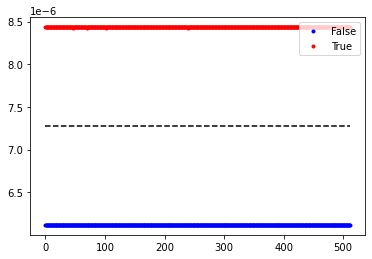

In [19]:
plt.plot(
    mse[np.logical_not(y_test)],
    color = "#0000ff",
    marker = ".",
    linestyle = "None",
    label = "False"
)
plt.plot(
    mse[y_test],
    color = "#ff0000",
    marker = ".",
    linestyle = "None",
    label = "True"
)
plt.plot(
    np.full(len(mse[y_test]),thresh),
    color = "#000000",
    linestyle = "--"
)
plt.legend()
plt.show()

In [22]:
from sklearn.cluster import KMeans
km_model = KMeans(n_clusters=2,random_state=10).fit(mse[:,np.newaxis])
labels = km_model.labels_

In [23]:
print(km_model.cluster_centers_)

[[6.11800231e-06]
 [8.43185224e-06]]


In [24]:
from sklearn.metrics.cluster import adjusted_rand_score
ari = adjusted_rand_score(y_test,km_model.labels_)
print(ari)

1.0
